In [1]:
from datetime import datetime
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
df = pd.read_csv('time_series_covid19_confirmed_US.csv')
df

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,5184,5198,5227,5257,5270,5327,5358,5376,5407,5440
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,16251,16346,16513,16653,16798,16981,17128,17256,17333,17496
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,1729,1730,1738,1760,1778,1793,1805,1827,1834,1882
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,2151,2162,2170,2188,2198,2212,2223,2223,2229,2247
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,5304,5308,5320,5376,5411,5439,5462,5473,5485,5517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,2685,2753,2769,2788,2847,2870,2870,2931,2981,2993
3336,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,1817,1833,1843,1852,1874,1887,1887,1900,1913,1925
3337,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3338,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,843,844,846,846,848,853,853,858,861,863


In [3]:
date = df.columns[-1]
latest_count = df.loc[df.Province_State == 'California', ['Admin2', date]]
latest_count = latest_count.sort_values(by=date, ascending=False)
latest_count.head(10)

,Admin2,1/26/21
213,Los Angeles,1085488
231,San Bernardino,268542
228,Riverside,266849
224,Orange,239175
232,San Diego,230066
238,Santa Clara,99174
209,Kern,91119
204,Fresno,86336
229,Sacramento,84653
195,Alameda,71298


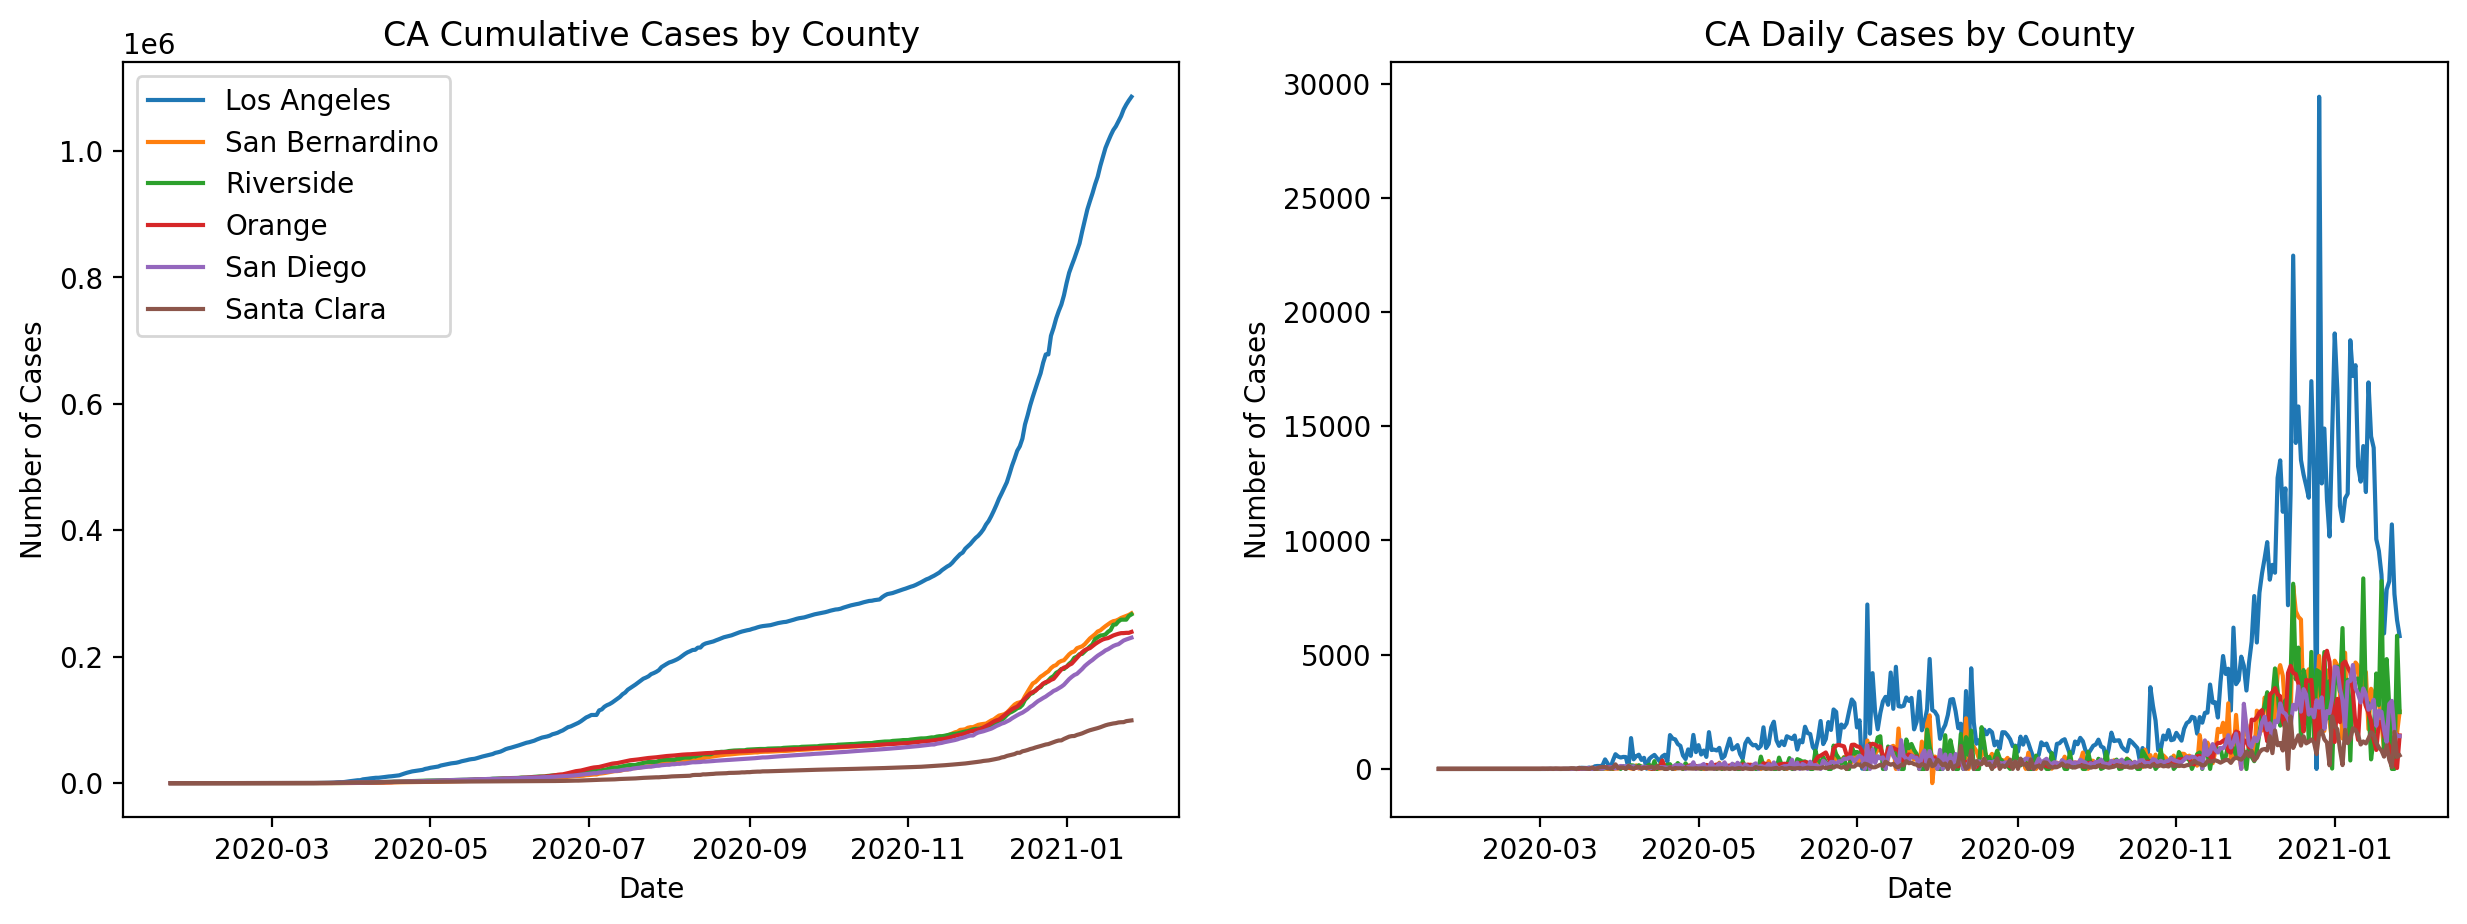

In [4]:
n = 6
county = latest_count.Admin2.values[:n]

index = 11
dates = [datetime.strptime(d, '%m/%d/%y') for d in df.columns[index:]]

fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=200)

for c in county:
    cases = df[df.Admin2 == c].values[0][index:]
    ax[0].plot(dates, cases)
    
    cases = [0] + [cases[i]-cases[i-1] for i in range(1, len(cases))]
    ax[1].plot(dates, cases)
    
ax[0].legend(county)

ax[0].set_xlabel('Date')
ax[1].set_xlabel('Date')
ax[0].set_ylabel('Number of Cases')
ax[1].set_ylabel('Number of Cases')

ax[0].set_title('CA Cumulative Cases by County')
ax[1].set_title('CA Daily Cases by County')

plt.savefig('covid_cases_ca_county', bbox_inches='tight')

In [5]:
dft = df.iloc[:, 11:].transpose().rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
dft = dft.iloc[1:]
dft

,0,1,2,3,4,5,6,7,8,9,...,3330,3331,3332,3333,3334,3335,3336,3337,3338,3339
1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/27/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1/22/21,57.0,183.0,15.0,14.0,28.0,8.0,11.0,76.0,38.0,18.0,...,-1.0,-2.0,13.0,1.0,14.0,23.0,13.0,0.0,5.0,0.0
1/23/21,31.0,147.0,12.0,11.0,23.0,11.0,7.0,55.0,23.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/24/21,18.0,128.0,22.0,0.0,11.0,2.0,13.0,25.0,8.0,6.0,...,14.0,1.0,4.0,1.0,27.0,61.0,13.0,0.0,5.0,1.0
1/25/21,31.0,77.0,7.0,6.0,12.0,11.0,4.0,34.0,12.0,3.0,...,-3.0,2.0,10.0,0.0,7.0,50.0,13.0,0.0,3.0,0.0


In [6]:
def get_list(x, m):
    return list(zip(*(x[i:] for i in range(m))))

In [7]:
w = 5
x = []

for i in range(dft.shape[1]):
    x.extend(get_list(dft[i], w+1))

x = np.array(x)

y = torch.tensor(x[:, -1])
x = torch.tensor(np.hstack((x[:, :-1], np.random.normal(0, 0.1, size=(x.shape[0], 1)))))

In [8]:
x.shape

torch.Size([1219100, 6])

In [9]:
class AutoRegressive(nn.Module):
    def __init__(self, p):
        # initialize model
        super(AutoRegressive, self).__init__()
        
        # check order type and value
        assert type(p) == int
        assert p >= 0
        
        # set model order
        self.p = p
        
        # initialize model weights
        self.linear = nn.Linear(self.p, 1, bias=True).double()
        
    def forward(self, x):
        # verify tensor has correct length
        assert x.shape[1] == self.p + 1
        
        # calculate model prediction
        return self.linear(x[:, :-1]).flatten()

In [10]:
net = AutoRegressive(w)

In [11]:
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001)
criterion = torch.nn.MSELoss(reduction='sum')

In [12]:
loader = DataLoader(
    TensorDataset(x, y), batch_size=128, shuffle=True
)

In [13]:
n_epochs = 10

for e in range(n_epochs):
    loss_total = 0
    for xi, yi in loader:
        xi, yi = xi.to('cpu'), yi.to('cpu')
        optimizer.zero_grad()
        prediction = net(xi)
        loss = criterion(yi, prediction)
        loss.backward()
        optimizer.step()
        loss_total += loss
        
    print(e, loss_total / len(y))

0 tensor(5525.6802, dtype=torch.float64, grad_fn=<DivBackward0>)
1 tensor(5021.8304, dtype=torch.float64, grad_fn=<DivBackward0>)
2 tensor(4961.3950, dtype=torch.float64, grad_fn=<DivBackward0>)
3 tensor(4928.2077, dtype=torch.float64, grad_fn=<DivBackward0>)
4 tensor(4910.2737, dtype=torch.float64, grad_fn=<DivBackward0>)
5 tensor(4937.5186, dtype=torch.float64, grad_fn=<DivBackward0>)
6 tensor(4961.7363, dtype=torch.float64, grad_fn=<DivBackward0>)
7 tensor(4970.7486, dtype=torch.float64, grad_fn=<DivBackward0>)
8 tensor(4957.6080, dtype=torch.float64, grad_fn=<DivBackward0>)
9 tensor(4925.4769, dtype=torch.float64, grad_fn=<DivBackward0>)


In [14]:
c = 'San Diego'
cases = df[df.Admin2 == c].values[0][index:]
cases = np.array([0] + [cases[i]-cases[i-1] for i in range(1, len(cases))])
pred = np.zeros_like(cases)

for i in range(w,len(cases)):
    pred[i] = net(torch.tensor(np.hstack((cases[i-w:i], np.random.normal(0, 0.1)))).view(1, w+1).double())

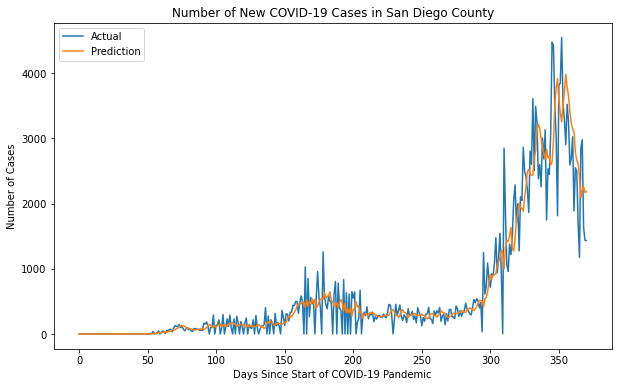

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(cases)
plt.plot(pred)
plt.xlabel('Days Since Start of COVID-19 Pandemic')
plt.ylabel('Number of Cases')
plt.legend(['Actual', 'Prediction'])
plt.title(f'Number of New COVID-19 Cases in {c} County')
plt.savefig('covid_prediction', bbox_inches='tight')